In [180]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time
import gym

# Set random seed 
import random
random.seed(27)

# Only warn once
import warnings
warnings.filterwarnings('ignore')

# Plot inline
%matplotlib inline

In [7]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [34]:
# Validate Blackjack-v0 environment
# Print syntax adopted from https://github.com/dennybritz/reinforcement-learning/blob/master/MC/Blackjack%20Playground.ipynb

env = gym.make('Blackjack-v0')
done = False

score = []
it_steps = []
obs = []

# Simulate 5 episodes
for i in range(5):
    new_state = env.reset()
    done = False
    steps = 0
    obs.append(new_state)
    print(new_state)
    #str = join(new_state)
    #Encode observation
    hand = (new_state[0])**2
    dealer = new_state[1]
    if new_state[2] == True:
        ua = 1
    else:
        ua = 0
    encoded_state = hand+dealer+ua
    print(encoded_state)
    
    while done == False:
        my_score, dealer_score, usable_ace = new_state
        print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(my_score, usable_ace, dealer_score))
        action = env.action_space.sample()
        print("Taking action: {}".format( ["Stick", "Hit"][action]))
        new_state, reward, done, info = env.step(action)
        obs.append(new_state)
        score.append(reward)
        
        if done == True:
            my_score, dealer_score, usable_ace = new_state
            print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(my_score, usable_ace, dealer_score))
            print("Game end. Reward: {}\n".format(float(reward)))
        steps += 1
        it_steps.append(steps)
        
print(it_steps)
print(score)
print(obs)

(14, 1, False)
197
Player Score: 14 (Usable Ace: False), Dealer Score: 1
Taking action: Stick
Player Score: 14 (Usable Ace: False), Dealer Score: 1
Game end. Reward: -1.0

(16, 2, False)
258
Player Score: 16 (Usable Ace: False), Dealer Score: 2
Taking action: Hit
Player Score: 19 (Usable Ace: False), Dealer Score: 2
Taking action: Stick
Player Score: 19 (Usable Ace: False), Dealer Score: 2
Game end. Reward: 1.0

(14, 6, False)
202
Player Score: 14 (Usable Ace: False), Dealer Score: 6
Taking action: Hit
Player Score: 22 (Usable Ace: False), Dealer Score: 6
Game end. Reward: -1.0

(18, 7, True)
332
Player Score: 18 (Usable Ace: True), Dealer Score: 7
Taking action: Stick
Player Score: 18 (Usable Ace: True), Dealer Score: 7
Game end. Reward: 1.0

(17, 2, False)
291
Player Score: 17 (Usable Ace: False), Dealer Score: 2
Taking action: Hit
Player Score: 27 (Usable Ace: False), Dealer Score: 2
Game end. Reward: -1.0

[1, 1, 2, 1, 1, 1]
[-1.0, 0, 1.0, -1, 1.0, -1]
[(14, 1, False), (14, 1, Fals

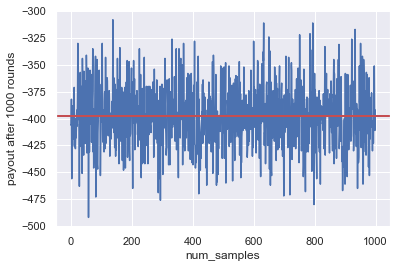

Average payout after 1000 rounds is -397.735
Win Percentage: 0.27972


In [156]:
# Simulation adopted from https://curiouscoder.space/blog/machine%20learning/teaching-a-computer-blackjack-using-reinforcement-learning/

env = gym.make('Blackjack-v0')
env.reset()

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []
wins = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            if payout > 0:
                wins.append(1)
            else:
                wins.append(0)
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

avg_payout = sum(average_payouts)/num_samples
win_pct = sum(wins)/len(wins)

sns.set(color_codes=True)
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.axhline(y = avg_payout, linewidth=2, color='r')
plt.grid(True)
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))
print ("Win Percentage: %s"%win_pct)

In [113]:
def create_experience_matrix():
    P = {s : {a : [] for a in range(2)} for s in range(3,26)}

    for hand in range(3, 26): # Sum of my hand
        for a in range(2):
            s = hand
            li = P[s][a]
            if hand >= 21:
                li.append((1.0, s, 0, True))
                continue
            else:
            # Stick
                if a == 0 and hand >= 18:
                    next_state = hand
                    reward = 0
                    li.append((0.8, next_state, reward, False))
                elif a == 0 and hand < 18:
                    next_state = hand
                    reward = 0
                    li.append((0.8, next_state, reward, False))
                # Hit
                for card in range(2, 12):
                    if a == 1 and hand >= 18:
                        next_state = hand + card
                        reward = 0
                        if next_state == 21:
                            reward = 100
                        elif next_state >= 21:
                            reward = -100
                        else:
                            reward = 0
                        li.append((0.2, next_state, reward, False))
                    elif a == 1 and hand < 18:
                        next_state = hand + card
                        reward = 0
                        if next_state == 21:
                            reward = 100
                        elif next_state >= 21:
                            reward = -100
                        else:
                            reward = 0
                        li.append((0.8, next_state, reward, False))
                    else:
                        next_state = hand
    return P
P = create_experience_matrix()
print(P)

{3: {0: [(0.8, 3, 0, False)], 1: [(0.8, 5, 0, False), (0.8, 6, 0, False), (0.8, 7, 0, False), (0.8, 8, 0, False), (0.8, 9, 0, False), (0.8, 10, 0, False), (0.8, 11, 0, False), (0.8, 12, 0, False), (0.8, 13, 0, False), (0.8, 14, 0, False)]}, 4: {0: [(0.8, 4, 0, False)], 1: [(0.8, 6, 0, False), (0.8, 7, 0, False), (0.8, 8, 0, False), (0.8, 9, 0, False), (0.8, 10, 0, False), (0.8, 11, 0, False), (0.8, 12, 0, False), (0.8, 13, 0, False), (0.8, 14, 0, False), (0.8, 15, 0, False)]}, 5: {0: [(0.8, 5, 0, False)], 1: [(0.8, 7, 0, False), (0.8, 8, 0, False), (0.8, 9, 0, False), (0.8, 10, 0, False), (0.8, 11, 0, False), (0.8, 12, 0, False), (0.8, 13, 0, False), (0.8, 14, 0, False), (0.8, 15, 0, False), (0.8, 16, 0, False)]}, 6: {0: [(0.8, 6, 0, False)], 1: [(0.8, 8, 0, False), (0.8, 9, 0, False), (0.8, 10, 0, False), (0.8, 11, 0, False), (0.8, 12, 0, False), (0.8, 13, 0, False), (0.8, 14, 0, False), (0.8, 15, 0, False), (0.8, 16, 0, False), (0.8, 17, 0, False)]}, 7: {0: [(0.8, 7, 0, False)], 1: [

In [275]:
# Value iteration adopted from https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa

import numpy as np
import gym
from gym import wrappers


# Value Itertaion
def create_experience_matrix():
    P = {s : {a : [] for a in range(2)} for s in range(3,26)}

    for hand in range(3, 26): # Sum of my hand
        for a in range(2):
            s = hand
            li = P[s][a]
            if hand >= 21:
                li.append((1.0, s, 0, True))
                continue
            else:
            # Stick
                if a == 0 and hand >= 18:
                    next_state = hand
                    reward = 0
                    li.append((0.8, next_state, reward, False))
                elif a == 0 and hand < 18:
                    next_state = hand
                    reward = 0
                    li.append((0.8, next_state, reward, False))
                # Hit
                for card in range(2, 12):
                    if a == 1 and hand >= 18:
                        next_state = hand + card
                        reward = 0
                        if next_state == 21:
                            reward = 100
                        elif next_state >= 21:
                            reward = -100
                        else:
                            reward = 0
                        li.append((0.2, next_state, reward, False))
                    elif a == 1 and hand < 18:
                        next_state = hand + card
                        reward = 0
                        if next_state == 21:
                            reward = 100
                        elif next_state >= 21:
                            reward = -100
                        else:
                            reward = 0
                        li.append((0.8, next_state, reward, False))
                    else:
                        next_state = hand
    return P
#P = create_experience_matrix()
#print(P)

def encode_obs(new_state):
    #Encode observation
    hand = new_state[0]
    dealer = new_state[1]
    if new_state[2] == True:
        ua = 1
    else:
        ua = 0
    encoded_state = int(hand+dealer+ua)
    #print(encoded_state)
    #print(type(encoded_state))
    return encoded_state

def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    obs = encode_obs(obs)
    total_reward = 0
    rounds = 1
    max_rounds = 100
    
    while rounds <= max_rounds:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        obs = encode_obs(obs)
        total_reward += (gamma ** rounds * reward)
        if done:
            env.reset()
        rounds+= 1
            
    return total_reward, rounds

def evaluate_policy(env, policy, gamma = 1.0,  n = 10):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    ev_scores = []
    ev_steps = []
    for i in range(n):
        scores, steps = run_episode(env, policy, gamma = gamma, render = False)
        ev_scores.append(scores)
        ev_steps.append(steps)
    #scores, steps = [
    #        run_episode(env, policy, gamma = gamma, render = False)
    #        for _ in range(n)]
    return np.mean(ev_scores), np.mean(ev_steps)

def extract_policy(v, gamma = 1.0):
    nS = 50
    nA = 2
    """ Extract the policy given a value-function """
    policy = np.zeros(nS)
    for s in range(3, 26):
        q_sa = np.zeros(nA)
        for a in range(nA):
            for next_sr in P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, gamma = 1.0, training_iters = 1000):
    """ Value-iteration algorithm """
    P = create_experience_matrix()
    score = []
    cum_score = []
    steps = []
    runtime = []
    nS = 50
    nA = 2
    r = 2
    psa = np.zeros([nS, nA, r])
    
    iteration_converged = 0
    v = np.zeros(nS)  # initialize value-function
    max_iterations = 1000
    total_score = 0
    eps = 1e-20
    for i in range(max_iterations):
        # Start timing
        t0 = time.time()
        
        #print(i)
        prev_v = np.copy(v)
        for s in range(3,26):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in P[s][a]]) for a in range(nA)] 
            v[s] = max(q_sa)
            
        policy = extract_policy(v, gamma)
        iteration_score, rounds = evaluate_policy(env, policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score) 
        cum_score.append(total_score)
        steps.append(rounds)
        
        if (np.sum(np.fabs(prev_v - v)) <= eps) or (i == training_iters):
            print ('Value-iteration converged at iteration# %d.' %(i))
            iteration_converged = i
            # Iteration stoptime
            t1 = time.time()
            run = t1-t0
            runtime.append(run)
            break
        # Iteration stoptime
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
        
    iterations_remaining = max_iterations - i
    
    for rem in range(iterations_remaining):
        #policy = extract_policy(v, gamma)
        t0 = time.time()
        iteration_score, rounds = evaluate_policy(env, policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score)
        cum_score.append(total_score)
        steps.append(rounds)
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
      
    simulate_env(policy)
    
    return v, score, cum_score, iteration_converged, steps, runtime


# Simulation adopted from https://curiouscoder.space/blog/machine%20learning/teaching-a-computer-blackjack-using-reinforcement-learning/
def simulate_env(policy):
    env = gym.make('Blackjack-v0')
    #env.reset()

    # Reset the environment
    obs = env.reset()
    obs = encode_obs(obs)

    num_rounds = 1000 # Payout calculated over num_rounds
    num_samples = 1000 # num_rounds simulated over num_samples
    total_payout = 0
    average_payouts = []
    wins = []
    
    for sample in range(num_samples):
        round = 1
        total_payout = 0 # to store total payout over 'num_rounds'

        while round <= num_rounds:
            #if state in qtable:
            #    print(True)
            #obs = encode_obs(obs)
            obs, payout, done , _ = env.step(int(policy[obs]))
            obs = encode_obs(obs)
            total_payout += payout
            
            if is_done:
                if payout > 0:
                    wins.append(1)
                else:
                    wins.append(0)
                env.reset() # Environment deals new cards to player and dealer
                round += 1
                
        average_payouts.append(total_payout)

    avg_payout = sum(average_payouts)/num_samples
    win_pct = sum(wins)/len(wins)
    
    sns.set(color_codes=True)
    plt.plot(average_payouts)                
    plt.xlabel('num_samples')
    plt.ylabel('payout after 1000 rounds')
    plt.axhline(y = avg_payout, linewidth=2, color='r')
    plt.grid(True)
    plt.show()    
    print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))
    print ("Win Percentage: %s"%win_pct)

Value-iteration converged at iteration# 4.


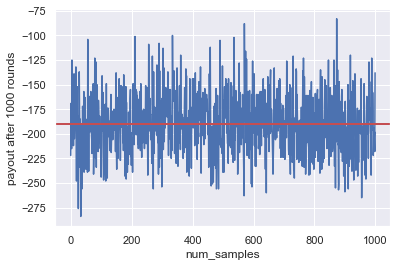

Average payout after 1000 rounds is -190.311
Win Percentage: 0.373862
Value-iteration converged at iteration# 4.


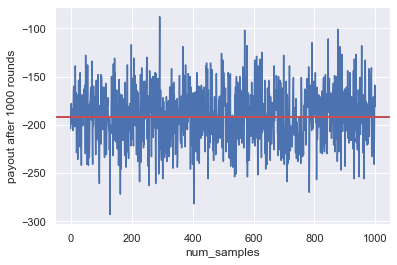

Average payout after 1000 rounds is -191.529
Win Percentage: 0.372996
Value-iteration converged at iteration# 4.


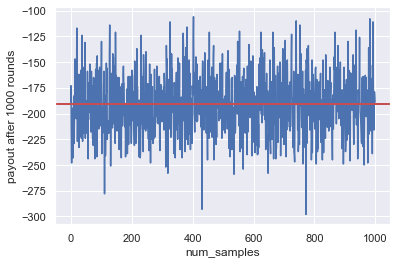

Average payout after 1000 rounds is -191.025
Win Percentage: 0.373558
Wall time: 2min 16s


In [276]:
%%time
env = gym.make('Blackjack-v0')
env.reset()
optimal_p_g25, score_gamma25, cum_score_gamma25, iteration_converged_g25, steps_g25, rung25 = value_iteration(env, gamma = 0.25, training_iters = 500);
optimal_p_g60, score_gamma60, cum_score_gamma60, iteration_converged_g60, steps_g60, rung60 = value_iteration(env, gamma = 0.6, training_iters = 500);
optimal_p_g99, score_gamma99, cum_score_gamma99, iteration_converged_g99, steps_g99, rung99 = value_iteration(env, gamma = 0.99, training_iters = 500);

Value-iteration converged at iteration# 4.


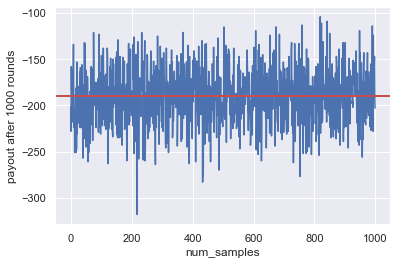

Average payout after 1000 rounds is -190.325
Win Percentage: 0.373549
Value-iteration converged at iteration# 4.


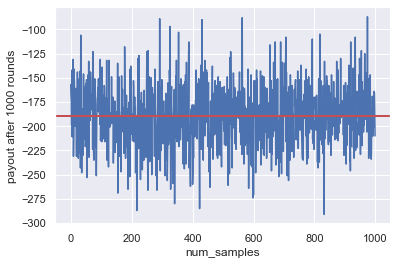

Average payout after 1000 rounds is -189.426
Win Percentage: 0.374321
Value-iteration converged at iteration# 4.


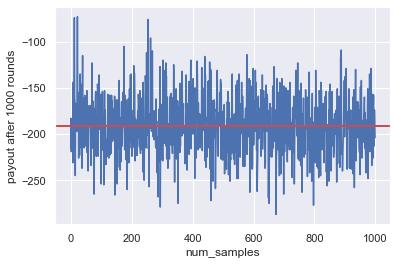

Average payout after 1000 rounds is -191.137
Win Percentage: 0.37332


In [279]:
gamma = 1.0
env = gym.make('Blackjack-v0')
env.reset()
optimal_v_100, score_100, cum_score_100, iteration_converged_100, steps_100, run_vi100 = value_iteration(env, gamma, training_iters = 100);
optimal_v_1000, score_1000, cum_score_1000, iteration_converged_1000, steps_1000, run_vi1000 = value_iteration(env, gamma, training_iters = 1000);
optimal_v_5000, score_5000, cum_score_5000, iteration_converged_5000, steps_5000, run_vi_5000 = value_iteration(env, gamma, training_iters = 5000);

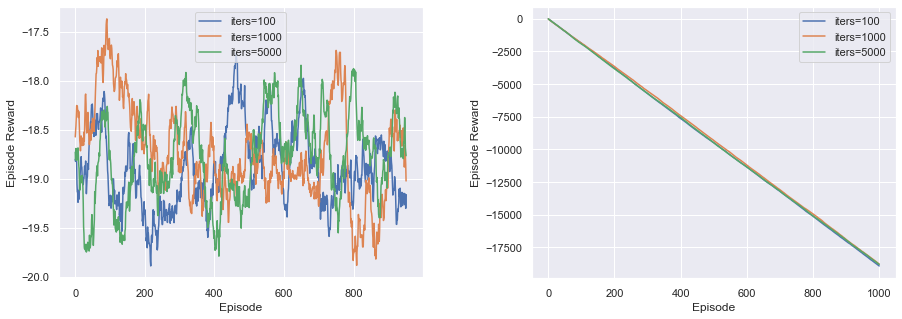

In [282]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=50)
ma_score_1000 = moving_average(score_1000, n=50)
ma_score_5000 = moving_average(score_5000, n=50)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(ma_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(cum_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()

In [283]:
import numpy as np
import gym
from gym import wrappers

# Policy iteration adopted from https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa

# Policy
def create_experience_matrix():
    P = {s : {a : [] for a in range(2)} for s in range(3,26)}

    for hand in range(3, 26): # Sum of my hand
        for a in range(2):
            s = hand
            li = P[s][a]
            if hand >= 21:
                li.append((1.0, s, 0, True))
                continue
            else:
            # Stick
                if a == 0 and hand >= 18:
                    next_state = hand
                    reward = 0
                    li.append((0.8, next_state, reward, False))
                elif a == 0 and hand < 18:
                    next_state = hand
                    reward = 0
                    li.append((0.8, next_state, reward, False))
                # Hit
                for card in range(2, 12):
                    if a == 1 and hand >= 18:
                        next_state = hand + card
                        reward = 0
                        if next_state == 21:
                            reward = 100
                        elif next_state >= 21:
                            reward = -100
                        else:
                            reward = 0
                        li.append((0.2, next_state, reward, False))
                    elif a == 1 and hand < 18:
                        next_state = hand + card
                        reward = 0
                        if next_state == 21:
                            reward = 100
                        elif next_state >= 21:
                            reward = -100
                        else:
                            reward = 0
                        li.append((0.8, next_state, reward, False))
                    else:
                        next_state = hand
    return P
#P = create_experience_matrix()
#print(P)

def encode_obs(new_state):
    #Encode observation
    hand = new_state[0]
    dealer = new_state[1]
    if new_state[2] == True:
        ua = 1
    else:
        ua = 0
    encoded_state = int(hand+dealer+ua)
    #print(encoded_state)
    #print(type(encoded_state))
    return encoded_state

def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    obs = encode_obs(obs)
    total_reward = 0
    rounds = 1
    max_rounds = 100
    
    while rounds <= max_rounds:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        obs = encode_obs(obs)
        total_reward += (gamma ** rounds * reward)
        if done:
            env.reset()
        rounds+= 1
            
    return total_reward, rounds

def evaluate_policy(env, policy, gamma = 1.0,  n = 10):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    ev_scores = []
    ev_steps = []
    for i in range(n):
        scores, steps = run_episode(env, policy, gamma = gamma, render = False)
        ev_scores.append(scores)
        ev_steps.append(steps)
    #scores, steps = [
    #        run_episode(env, policy, gamma = gamma, render = False)
    #        for _ in range(n)]
    return np.mean(ev_scores), np.mean(ev_steps)

def extract_policy(v, gamma = 1.0):
    nS = 50
    nA = 2
    """ Extract the policy given a value-function """
    policy = np.zeros(nS)
    for s in range(3, 26):
        q_sa = np.zeros(nA)
        for a in range(nA):
            for next_sr in P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma=1.0):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    nS = 50
    nA = 2
    v = np.zeros(nS)
    eps = 1e-10
    while True:
        prev_v = np.copy(v)
        for s in range(3, 26):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
            
    return v

def policy_iteration(env, gamma = 1.0, training_iters = 1000):
    """ Policy-Iteration algorithm """
    P = create_experience_matrix()
    score = []
    cum_score = []
    steps = []
    runtime = []
    nS = 50
    nA = 2
    gamma = gamma 
    
    v = np.zeros(nS)  # initialize value-function
    max_iterations = 1000
    total_score = 0   
    
    policy = np.random.choice(nA, size=(nS))  # initialize a random policy
    for i in range(max_iterations):
        t0 = time.time()
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        iteration_score, steps_idx = evaluate_policy(env, new_policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score) 
        cum_score.append(total_score)
        steps.append(steps_idx)
        
        if (np.all(policy == new_policy)) or (i == training_iters):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            iteration_converged = i
            t1 = time.time()
            run = t1-t0
            runtime.append(run)
            break
        policy = new_policy
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
        
    iterations_remaining = max_iterations - i
    
    for rem in range(iterations_remaining):
        #policy = extract_policy(v, gamma)
        t0 = time.time()
        iteration_score, steps_idx = evaluate_policy(env, new_policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score)
        cum_score.append(total_score)
        steps.append(steps_idx)
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
        
    simulate_env(policy)
            
    return policy, score, cum_score, iteration_converged, steps, runtime

# Simulation adopted from https://curiouscoder.space/blog/machine%20learning/teaching-a-computer-blackjack-using-reinforcement-learning/
def simulate_env(policy):
    env = gym.make('Blackjack-v0')
    #env.reset()

    # Reset the environment
    obs = env.reset()
    obs = encode_obs(obs)

    num_rounds = 1000 # Payout calculated over num_rounds
    num_samples = 1000 # num_rounds simulated over num_samples
    total_payout = 0
    average_payouts = []
    wins = []
    
    for sample in range(num_samples):
        round = 1
        total_payout = 0 # to store total payout over 'num_rounds'

        while round <= num_rounds:
            #if state in qtable:
            #    print(True)
            #obs = encode_obs(obs)
            obs, payout, done , _ = env.step(int(policy[obs]))
            obs = encode_obs(obs)
            total_payout += payout
            
            if is_done:
                if payout > 0:
                    wins.append(1)
                else:
                    wins.append(0)
                env.reset() # Environment deals new cards to player and dealer
                round += 1
                
        average_payouts.append(total_payout)

    avg_payout = sum(average_payouts)/num_samples
    win_pct = sum(wins)/len(wins)
    
    sns.set(color_codes=True)
    plt.plot(average_payouts)                
    plt.xlabel('num_samples')
    plt.ylabel('payout after 1000 rounds')
    plt.axhline(y = avg_payout, linewidth=2, color='r')
    plt.grid(True)
    plt.show()    
    print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))
    print ("Win Percentage: %s"%win_pct)

Policy-Iteration converged at step 4.


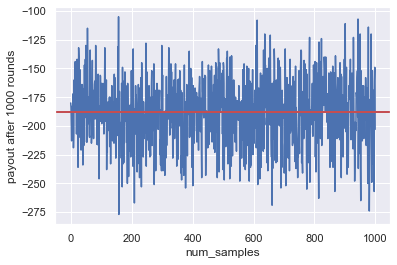

Average payout after 1000 rounds is -188.034
Win Percentage: 0.379889
Policy-Iteration converged at step 4.


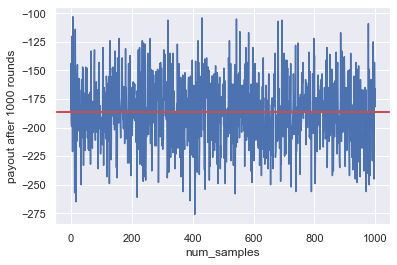

Average payout after 1000 rounds is -186.66
Win Percentage: 0.380711
Policy-Iteration converged at step 4.


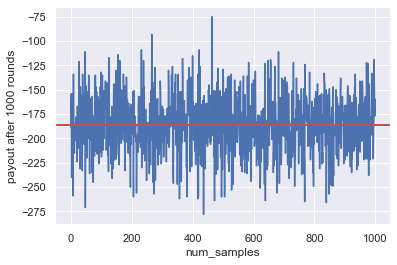

Average payout after 1000 rounds is -185.668
Win Percentage: 0.381001


In [305]:
gamma = 1.0
env = gym.make('Blackjack-v0')
env.reset()
optimal_p_100, score_100, cum_score_100, iteration_converged_100, steps_100, runt_pi100 = policy_iteration(env, gamma, training_iters = 100);
optimal_p_1000, score_1000, cum_score_1000, iteration_converged_1000, steps_1000, run_pi1000 = policy_iteration(env, gamma, training_iters = 1000);
optimal_p_5000, score_5000, cum_score_5000, iteration_converged_5000, steps_5000, run_pi5000 = policy_iteration(env, gamma, training_iters = 5000);

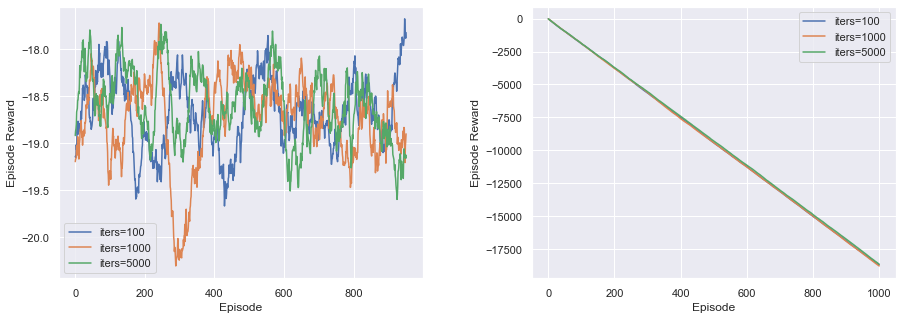

In [306]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=50)
ma_score_1000 = moving_average(score_1000, n=50)
ma_score_5000 = moving_average(score_5000, n=50)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(ma_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(cum_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()

Policy-Iteration converged at step 4.


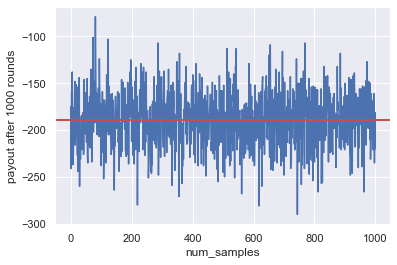

Average payout after 1000 rounds is -189.151
Win Percentage: 0.374024
Policy-Iteration converged at step 4.


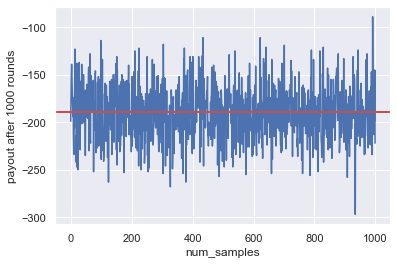

Average payout after 1000 rounds is -189.68
Win Percentage: 0.374013
Policy-Iteration converged at step 4.


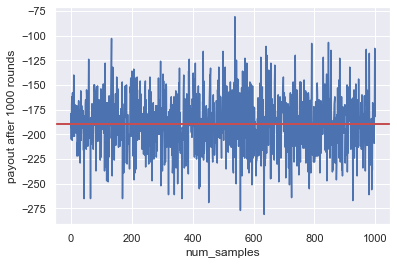

Average payout after 1000 rounds is -189.186
Win Percentage: 0.374068
Wall time: 2min 12s


In [285]:
%%time
env = gym.make('Blackjack-v0')
env.reset()
optimal_p_g25, score_gamma25, cum_score_gamma25, iteration_converged_g25, steps_g25, run_pig25 = policy_iteration(env, gamma = 0.25, training_iters = 500);
optimal_p_g60, score_gamma60, cum_score_gamma60, iteration_converged_g60, steps_g60, run_pig60 = policy_iteration(env, gamma = 0.6, training_iters = 500);
optimal_p_g99, score_gamma99, cum_score_gamma99, iteration_converged_g99, steps_g99, run_pig99 = policy_iteration(env, gamma = 0.99, training_iters = 500);

In [295]:
# Q-learning adopted from https://gist.github.com/simoninithomas/baafe42d1a665fb297ca669aa2fa6f92
def encode_obs(new_state):
    #Encode observation
    hand = new_state[0]
    dealer = new_state[1]
    if new_state[2] == True:
        ua = 1
    else:
        ua = 0
    encoded_state = int(hand+dealer+ua)
    #print(encoded_state)
    #print(type(encoded_state))
    return encoded_state

def Q_learning(env, epsilon = 1.0, decay = False, training_iters = 5000, simulation = False):
    if decay == False:
        total_episodes = 1000
    else:
        total_episodes = 1250        
    num_rounds = 100
    learning_rate = 0.5           # Learning rate
    max_steps = 99                # Max steps per episode
    gamma = 0.2               # Discounting rate
    qtable = np.zeros([50, 2])
    
    # Exploration parameters
    epsilon = epsilon                 # Exploration rate
    max_epsilon = 1.0             # Exploration probability at start
    min_epsilon = 0.01            # Minimum exploration probability 
    decay_rate = 0.005             # Exponential decay rate for exploration prob
    decay = decay
    
    # Metrics
    score = []
    cum_score = []
    runtime = []
    tot_score = 0
    
    # 2 For life or until learning is stopped
    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        state = encode_obs(state)
        done = False
        episode_rewards = 0
        rounds = 1
        t0 = time.time()
        while rounds <= num_rounds:
            exp_exp_tradeoff = random.uniform(0, 1)

            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if episode > training_iters:
                action = np.argmax(qtable[state])
            elif exp_exp_tradeoff > epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state])
            
            #action = env.action_space.sample()  # take random action 
            obs, payout, is_done, _ = env.step(action)
            new_state = encode_obs(obs)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            episode_rewards += payout

            # Our new state is state
            state = new_state
            
            if is_done:
                env.reset() # Environment deals new cards to player and dealer
                rounds += 1
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
        # Reduce epsilon (because we need less and less exploration)
        if decay == True:
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            #epsilon = epsilon * 0.999995
        tot_score += episode_rewards
        score.append(episode_rewards)
        cum_score.append(tot_score)
        #rewards.append(total_rewards)

    if simulation == True:
        simulate_env(qtable)
    
    return score, cum_score, steps, runtime

#print ("Score over time: " +  str(sum(score)/total_episodes))
#print(qtable)

# Simulation adopted from https://curiouscoder.space/blog/machine%20learning/teaching-a-computer-blackjack-using-reinforcement-learning/
def simulate_env(qtable):
    env = gym.make('Blackjack-v0')
    #env.reset()
    
    # Reset the environment
    state = env.reset()
    state = encode_obs(state)

    num_rounds = 1000 # Payout calculated over num_rounds
    num_samples = 1000 # num_rounds simulated over num_samples

    average_payouts = []
    wins = []
    
    for sample in range(num_samples):
        round = 1
        total_payout = 0 # to store total payout over 'num_rounds'

        while round <= num_rounds:
            #if state in qtable:
            #    print(True)
            action = np.argmax(qtable[state])
            #else:
            #    print(False)
            #    action = env.action_space.sample()

            #action = env.action_space.sample()  # take random action 
            obs, payout, is_done, _ = env.step(action)
            state = encode_obs(obs)
            total_payout += payout
            if is_done:
                if payout > 0:
                    wins.append(1)
                else:
                    wins.append(0)
                env.reset() # Environment deals new cards to player and dealer
                round += 1
        average_payouts.append(total_payout)

    avg_payout = sum(average_payouts)/num_samples
    win_pct = sum(wins)/len(wins)
    
    sns.set(color_codes=True)
    plt.plot(average_payouts)                
    plt.xlabel('num_samples')
    plt.ylabel('payout after 1000 rounds')
    plt.axhline(y = avg_payout, linewidth=2, color='r')
    plt.grid(True)
    plt.show()    
    print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))
    print ("Win Percentage: %s"%win_pct)


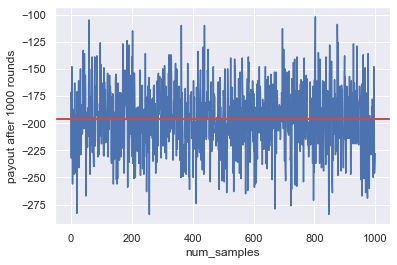

Average payout after 1000 rounds is -196.08
Win Percentage: 0.375582


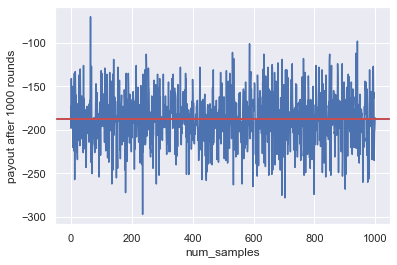

Average payout after 1000 rounds is -187.473
Win Percentage: 0.380413


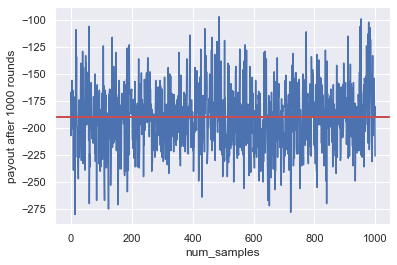

Average payout after 1000 rounds is -190.008
Win Percentage: 0.378929
Wall time: 1min 25s


In [296]:
%%time
env = gym.make('Blackjack-v0')
env.reset()
score_ep25, cum_score_ep25, steps_ep25, runq25 = Q_learning(env, epsilon = 0.25, decay = False, training_iters = 500, simulation = True);
score_ep60, cum_score_ep60, steps_ep60, runq60 = Q_learning(env, epsilon = 0.6, decay = False, training_iters = 500, simulation = True);
score_ep99, cum_score_ep99, steps_ep99, runq99 = Q_learning(env, epsilon = 0.99, decay = False, training_iters = 500, simulation = True);

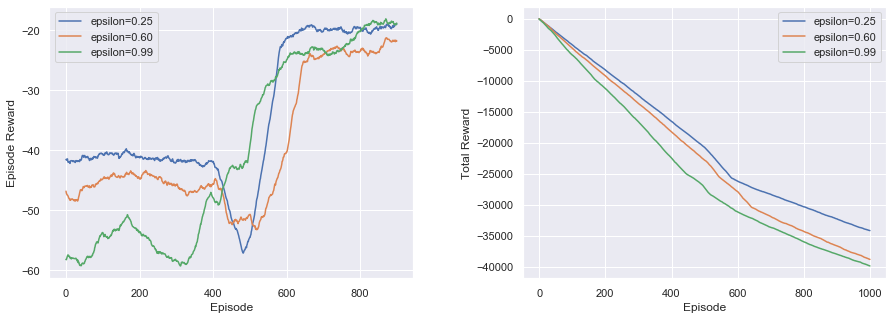

In [297]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_ep25 = moving_average(score_ep25, n=100)
ma_score_ep60 = moving_average(score_ep60, n=100)
ma_score_ep99 = moving_average(score_ep99, n=100)
ma_steps_ep25 = moving_average(steps_ep25, n=100)
ma_steps_ep60 = moving_average(steps_ep60, n=100)
ma_steps_ep99 = moving_average(steps_ep99, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(ma_score_ep25, label = 'epsilon=0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_ep60, label = 'epsilon=0.60')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_ep99, label = 'epsilon=0.99')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(cum_score_ep25, label = 'epsilon=0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_ep60, label = 'epsilon=0.60')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_ep99, label = 'epsilon=0.99')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
# plt.subplot(1,3,2)
# plt.plot(ma_steps_ep25, label = 'epsilon=0.25')
# #plt.axvline(x=iteration_converged_100, color = 'blue')
# plt.plot(ma_steps_ep60, label = 'epsilon=0.60')
# #plt.axvline(x=iteration_converged_1000, color = 'orange')
# plt.plot(ma_steps_ep99, label = 'epsilon=0.99')
# #plt.axvline(x=iteration_converged_5000, color = 'green')
# plt.xlabel('Episode')
# plt.ylabel('Number of Steps')
# plt.grid(True)
# plt.legend()

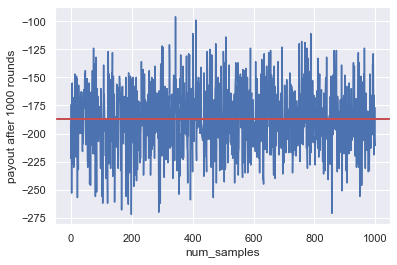

Average payout after 1000 rounds is -187.069
Win Percentage: 0.380519


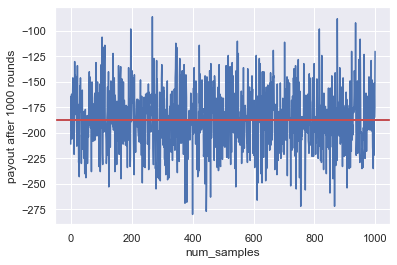

Average payout after 1000 rounds is -187.366
Win Percentage: 0.380215


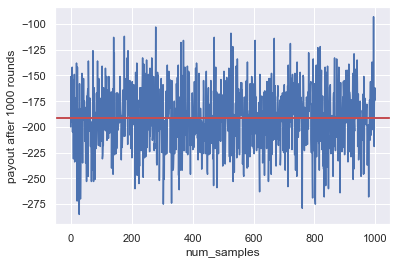

Average payout after 1000 rounds is -191.648
Win Percentage: 0.377781


In [298]:
epsilon = 0.99
env = gym.make('Blackjack-v0')
env.reset()
score_100, cum_score_100, steps_100, runq100 = Q_learning(env, epsilon, decay = True, training_iters = 100, simulation = True);
score_500, cum_score_500, steps_500, runq500 = Q_learning(env, epsilon, decay = True, training_iters = 500, simulation = True);
score_1000, cum_score_1000, steps_1000, runq1000 = Q_learning(env, epsilon, decay = True, training_iters = 1000, simulation = True);

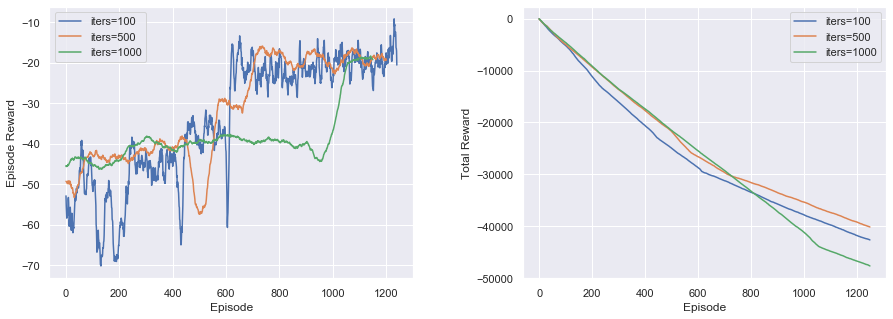

In [301]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=10)
ma_score_500 = moving_average(score_500, n=50)
ma_score_1000 = moving_average(score_1000, n=100)
ma_steps_100 = moving_average(steps_100, n=10)
ma_steps_500 = moving_average(steps_500, n=50)
ma_steps_1000 = moving_average(steps_1000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(ma_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_500, label = 'iters=500')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(cum_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_500, label = 'iters=500')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()

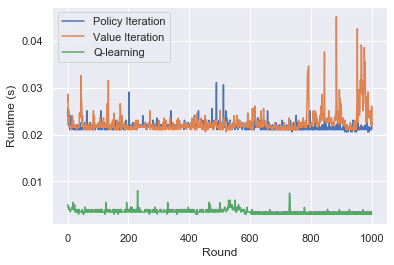

In [304]:
#https://stackoverflow.com/questions/37370015/what-is-the-difference-between-value-iteration-and-policy-iteration
plt.plot(run_pig25, label = 'Policy Iteration')
plt.plot(rung25, label = 'Value Iteration')
plt.plot(runq25, label = 'Q-learning')
plt.xlabel('Round')
plt.ylabel('Runtime (s)')
plt.legend()